# 1. Set up

In [ ]:
from helpers import helpers as h

import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import shap
import matplotlib.pyplot as plt

import category_encoders as ce
from joblib import dump
import plotnine
from plotnine import *
from yellowbrick.model_selection import RFECV

from lightgbm import LGBMClassifier

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline   
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("float_format", "{:.2f}".format)

In [ ]:
main_previous_HC_Bureau = pd.read_csv("main_loans_&_previous_HC_Bureau.csv")

In [ ]:
main_previous_HC_Bureau.shape

(307511, 89)

In [ ]:
h.missing_data(main_previous_HC_Bureau).head(2)

,Total,Percent
sk_id_curr,0,0.00
prev_min_loan_term_hc,0,0.00


In [ ]:
main_previous_HC_Bureau.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,flag_mobil,occupation_type,cnt_fam_members,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,organization_type,ext_source_1,ext_source_2,ext_source_3,def_30_cnt_social_circle,obs_60_cnt_social_circle,amt_req_credit_bureau_year,submitted_addit_docs,prop_of_unmatched_contact_perm_work_addr,prop_of_provided_living_place_info,prop_of_provided_phone_email_info,age_years,last_reg_change_in_years,last_phone_change_in_years,employment_years,id_published_years,age_bins,employment_bins,living_in_owning_realty,prev_approved_hc,prev_amt_credit_mean_hc,prev_amt_annuity_mean_hc,prev_min_loan_term_hc,prev_max_loan_term_hc,prev_days_from_last_approval_hc,approved_hc_name_contract_type_Cash loans_normalized,approved_hc_name_contract_type_Consumer loans_normalized,approved_hc_name_contract_type_Revolving loans_normalized,approved_hc_name_client_type_New_normalized,approved_hc_name_client_type_Refreshed_normalized,approved_hc_name_client_type_Repeater_normalized,approved_hc_name_client_type_XNA_normalized,approved_hc_name_yield_group_XNA_normalized,approved_hc_name_yield_group_high_normalized,approved_hc_name_yield_group_low_action_normalized,approved_hc_name_yield_group_low_normal_normalized,approved_hc_name_yield_group_middle_normalized,total_appl_hc,total_rejected_appl_hc,prev_reject_amt_appl_mean_hc,mean_delayed_days_per_all_loans_hc,total_delayed_days_per_all_loans_hc,total_future_instalments_by_other_credts_hc,total_active_credits_hc,total_defaults_previous_credits_hc,min_instal_amt_per_prev_credit_hc,max_instal_amt_per_prev_credit_hc,mean_instal_amt_per_prev_credit_hc,total_instalments_amt_prev_credit_hc,total_credit_cards_hc,max_total_per_1cred_card_limit_hc,mean_total_per_1cred_card_limit_hc,mean_drawings_per_1cred_card_hc,mean_credit_card_payment_hc,total_default_days_per_all_cred_cards_hc,total_defaults_credit_cards_hc,total_credits_bureau,total_credit_types_count_bureau,mean_day_overdue_per_card_bureau,mean_debt_per_card_bureau,mean_credit_per_card_bureau,avg_credits_prolonged_bureau,bureau_credit_active_Active_normalized,bureau_credit_active_Bad debt_normalized,bureau_credit_active_Closed_normalized,bureau_credit_active_Sold_normalized
0,100002,1,cash_loans,m,n,y,0,202500.00,406597.50,24700.50,351000.00,unaccompanied,working,secondary_secondary_special,single_not_married,house_apartment,0.02,1,laborers,1,2,wednesday,10,business_entity_type_3,0.08,0.26,0.14,1,2,1,0.05,0.00,0.14,0.50,25.92,9.99,3.11,1.75,5.81,"(25.0, 30.0]","(0.0, 5.0]",1,1.00,179055.00,9251.77,24.00,24.00,-606.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,6.00,1.00,0.00,11559.25,11559.25,11559.25,219625.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,2.00,0.00,30722.62,108131.95,0.00,0.25,0.00,0.75,0.00
1,100003,0,cash_loans,f,n,n,0,270000.00,1293502.50,35698.50,1129500.00,family,state_servant,higher_education,married,house_apartment,0.00,1,core_staff,2,1,monday,11,school,0.31,0.62,0.53,0,1,0,0.05,0.00,0.20,0.50,45.93,3.25,2.27,3.25,0.80,"(45.0, 50.0]","(0.0, 5.0]",0,3.00,484191.00,56553.99,6.00,12.00,-746.00,0.33,0.67,0.00,0.00,0.67,0.33,0.00,0.00,0.00,0.00,0.33,0.67,3.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,6731.12,164425.33,78558.48,1618864.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,2.00,0.00,0.00,254350.12,0.00,0.25,0.00,0.75,0.00
2,100004,0,revolving_loans,m,y,y,0,67500.00,135000.00,6750.00,135000.00,unaccompanied,working,secondary_secondary_special,single_not_married,house_apartment,0.01,1,laborers,1,2,monday,9,government,0.65,0.56,0.73,0,0,0,0.00,0.00,0.59,0.75,52.18,11.67,2.23,0.62,6.93,"(50.0, 55.0]","(0.0, 5.0]",1,1.00,20106.00,5357.25,4.00,4.00,-815.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.

# 2. Default prediction

### 2.1. Feature pre-processing

Pre-processing steps:
1. I'll try to change cyclic data (weekdays and hours) to cos_sin values (thats for linear models should be better to interpret).
2. As I have more than 90 features (plus encoding of categorical features), after setting the base line models, I'll try various feature selection techniques, to see which of them does the best and continue with some of them.
3. As data is imbalanced, I'll try resampling with SMOTE.

In [ ]:
total_default_df = (
    main_previous_HC_Bureau.pipe(h.copy_df)
    .pipe(h.weekdays_to_numbers, "weekday_appr_process_start")
    .pipe(h.cyclic_data_to_sin_cos, "hour_appr_process_start")
    .pipe(h.cyclic_data_to_sin_cos, "weekday_appr_process_start")
    .pipe(h.change_negative_to_positive, "prev_days_from_last_approval_hc")
    .pipe(h.change_dtype_category))

In [ ]:
total_default_df.head(2)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,flag_mobil,occupation_type,cnt_fam_members,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,organization_type,ext_source_1,ext_source_2,ext_source_3,def_30_cnt_social_circle,obs_60_cnt_social_circle,amt_req_credit_bureau_year,submitted_addit_docs,prop_of_unmatched_contact_perm_work_addr,prop_of_provided_living_place_info,prop_of_provided_phone_email_info,age_years,last_reg_change_in_years,last_phone_change_in_years,employment_years,id_published_years,age_bins,employment_bins,living_in_owning_realty,prev_approved_hc,prev_amt_credit_mean_hc,prev_amt_annuity_mean_hc,prev_min_loan_term_hc,prev_max_loan_term_hc,prev_days_from_last_approval_hc,approved_hc_name_contract_type_Cash loans_normalized,approved_hc_name_contract_type_Consumer loans_normalized,approved_hc_name_contract_type_Revolving loans_normalized,approved_hc_name_client_type_New_normalized,approved_hc_name_client_type_Refreshed_normalized,approved_hc_name_client_type_Repeater_normalized,approved_hc_name_client_type_XNA_normalized,approved_hc_name_yield_group_XNA_normalized,approved_hc_name_yield_group_high_normalized,approved_hc_name_yield_group_low_action_normalized,approved_hc_name_yield_group_low_normal_normalized,approved_hc_name_yield_group_middle_normalized,total_appl_hc,total_rejected_appl_hc,prev_reject_amt_appl_mean_hc,mean_delayed_days_per_all_loans_hc,total_delayed_days_per_all_loans_hc,total_future_instalments_by_other_credts_hc,total_active_credits_hc,total_defaults_previous_credits_hc,min_instal_amt_per_prev_credit_hc,max_instal_amt_per_prev_credit_hc,mean_instal_amt_per_prev_credit_hc,total_instalments_amt_prev_credit_hc,total_credit_cards_hc,max_total_per_1cred_card_limit_hc,mean_total_per_1cred_card_limit_hc,mean_drawings_per_1cred_card_hc,mean_credit_card_payment_hc,total_default_days_per_all_cred_cards_hc,total_defaults_credit_cards_hc,total_credits_bureau,total_credit_types_count_bureau,mean_day_overdue_per_card_bureau,mean_debt_per_card_bureau,mean_credit_per_card_bureau,avg_credits_prolonged_bureau,bureau_credit_active_Active_normalized,bureau_credit_active_Bad debt_normalized,bureau_credit_active_Closed_normalized,bureau_credit_active_Sold_normalized,cos_hour_appr_process_start,sin_hour_appr_process_start,cos_weekday_appr_process_start,sin_weekday_appr_process_start
0,100002,1,cash_loans,m,n,y,0,202500.00,406597.50,24700.50,351000.00,unaccompanied,working,secondary_secondary_special,single_not_married,house_apartment,0.02,1,laborers,1,2,3,10,business_entity_type_3,0.08,0.26,0.14,1,2,1,0.05,0.00,0.14,0.50,25.92,9.99,3.11,1.75,5.81,"(25.0, 30.0]","(0.0, 5.0]",1,1.00,179055.00,9251.77,24.00,24.00,606.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,6.00,1.00,0.00,11559.25,11559.25,11559.25,219625.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,2.00,0.00,30722.62,108131.95,0.00,0.25,0.00,0.75,0.00,-0.92,0.40,-0.90,0.43
1,100003,0,cash_loans,f,n,n,0,270000.00,1293502.50,35698.50,1129500.00,family,state_servant,higher_education,married,house_apartment,0.00,1,core_staff,2,1,1,11,school,0.31,0.62,0.53,0,1,0,0.05,0.00,0.20,0.50,45.93,3.25,2.27,3.25,0.80,"(45.0, 50.0]","(0.0, 5.0]",0,3.00,484191.00,56553.99,6.00,12.00,746.00,0.33,0.67,0.00,0.00,0.67,0.33,0.00,0.00,0.00,0.00,0.33,0.67,3.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,6731.12,164425.33,78558.48,1618864.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,2.00,0.00,0.00,254350.12,0.00,0.25,0.00,0.75,0.00,-0.99,0.14,0.62,0.78


In [ ]:
total_default_df.describe()

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,flag_mobil,cnt_fam_members,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,ext_source_1,ext_source_2,ext_source_3,def_30_cnt_social_circle,obs_60_cnt_social_circle,amt_req_credit_bureau_year,submitted_addit_docs,prop_of_unmatched_contact_perm_work_addr,prop_of_provided_living_place_info,prop_of_provided_phone_email_info,age_years,last_reg_change_in_years,last_phone_change_in_years,employment_years,id_published_years,living_in_owning_realty,prev_approved_hc,prev_amt_credit_mean_hc,prev_amt_annuity_mean_hc,prev_min_loan_term_hc,prev_max_loan_term_hc,prev_days_from_last_approval_hc,approved_hc_name_contract_type_Cash loans_normalized,approved_hc_name_contract_type_Consumer loans_normalized,approved_hc_name_contract_type_Revolving loans_normalized,approved_hc_name_client_type_New_normalized,approved_hc_name_client_type_Refreshed_normalized,approved_hc_name_client_type_Repeater_normalized,approved_hc_name_client_type_XNA_normalized,approved_hc_name_yield_group_XNA_normalized,approved_hc_name_yield_group_high_normalized,approved_hc_name_yield_group_low_action_normalized,approved_hc_name_yield_group_low_normal_normalized,approved_hc_name_yield_group_middle_normalized,total_appl_hc,total_rejected_appl_hc,prev_reject_amt_appl_mean_hc,mean_delayed_days_per_all_loans_hc,total_delayed_days_per_all_loans_hc,total_future_instalments_by_other_credts_hc,total_active_credits_hc,total_defaults_previous_credits_hc,min_instal_amt_per_prev_credit_hc,max_instal_amt_per_prev_credit_hc,mean_instal_amt_per_prev_credit_hc,total_instalments_amt_prev_credit_hc,total_credit_cards_hc,max_total_per_1cred_card_limit_hc,mean_total_per_1cred_card_limit_hc,mean_drawings_per_1cred_card_hc,mean_credit_card_payment_hc,total_default_days_per_all_cred_cards_hc,total_defaults_credit_cards_hc,total_credits_bureau,total_credit_types_count_bureau,mean_day_overdue_per_card_bureau,mean_debt_per_card_bureau,mean_credit_per_card_bureau,avg_credits_prolonged_bureau,bureau_credit_active_Active_normalized,bureau_credit_active_Bad debt_normalized,bureau_credit_active_Closed_normalized,bureau_credit_active_Sold_normalized,cos_hour_appr_process_start,sin_hour_appr_process_start,cos_weekday_appr_process_start,sin_weekday_appr_process_start
count,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00
mean,278180.52,0.08,0.42,163167.92,599026.00,27108.58,537909.48,0.02,1.00,2.15,2.03,3.53,12.06,0.54,0.51,0.51,0.11,1.27,1.64,0.05,0.10,0.18,0.38,43.94,13.66,2.64,7.30,8.20,0.65,2.88,172829.83,13135.39,7.04,19.99,568.85,0.22,0.64,0.08,0.41,0.10,0.43,0.00,0.08,0.27,0.08,0.23,0.29,4.59,0.79,96047.83,184.57,330.74,5.72,0.56,0.22,9753.28,43111.06,21544.36,637718.26,0.28,1602655.56,1597436.35,78356.58,79778.67,99.67,0.06,4.77,1.49,0.89,117325.12,323955.44,0.01,0.35,0.00,0.50,0.00,-0.66,-0.10,-0.15,0.06
std,102790.18,0.27,0.72,72517.57,402490.78,14493.46,369633.75,0.01,0.00,0.91,0.50,1.79,3.27,0.18,0.19,0.18,0.32,1.82,1.86,0.02,0.18,0.22,0.18,11.96,9.65,2.27,6.05,4.14,0.48,2.18,177154.28,10090.90,7.20,15.02,565.27,0.30,0.36,0.16,0.36,0.21,0.36,0.01,0.16,0.33,0.21,0.31,0.33,4.18,1.77,254079.95,3682.85,5509.43,11.65,0.71

In [ ]:
# Identify and drop our target variable "target" from data frame.

X = total_default_df.drop(
    columns=[
        "sk_id_curr",
        "target"
    ],
    axis=1,
)

# Isolate our dependent variable as a feature
y = total_default_df.target

* Pre-processor.

In [ ]:
# Features.

binary_features = [
    "name_contract_type",
    "code_gender",
    "flag_own_car",
    "flag_own_realty",
]

categorical_features = [
    "name_housing_type",
    "name_type_suite",
    "occupation_type",
    "name_education_type",
    "name_family_status",
    "organization_type",
    "employment_bins",
    "age_bins",
    "name_income_type",
]

numerical_features = [
    "cnt_children", 
    "amt_income_total", 
    "amt_credit", 
    "amt_annuity",
    "amt_goods_price", 
    "cnt_fam_members", 
    "ext_source_1",
    "ext_source_2", 
    "ext_source_3", 
    "def_30_cnt_social_circle",
    "obs_60_cnt_social_circle", 
    "amt_req_credit_bureau_year",
    "submitted_addit_docs", 
    "prop_of_unmatched_contact_perm_work_addr",
    "prop_of_provided_living_place_info",
    "prop_of_provided_phone_email_info", 
    "age_years",
    "last_reg_change_in_years", 
    "last_phone_change_in_years",
    "employment_years", 
    "id_published_years", 
    "living_in_owning_realty",
    "prev_approved_hc", 
    "prev_amt_credit_mean_hc",
    "prev_amt_annuity_mean_hc", 
    "prev_min_loan_term_hc",
    "prev_max_loan_term_hc", 
    "prev_days_from_last_approval_hc",
    "approved_hc_name_contract_type_Cash loans_normalized",
    "approved_hc_name_contract_type_Consumer loans_normalized",
    "approved_hc_name_contract_type_Revolving loans_normalized",
    "approved_hc_name_client_type_New_normalized",
    "approved_hc_name_client_type_Refreshed_normalized",
    "approved_hc_name_client_type_Repeater_normalized",
    "approved_hc_name_client_type_XNA_normalized",
    "approved_hc_name_yield_group_XNA_normalized",
    "approved_hc_name_yield_group_high_normalized",
    "approved_hc_name_yield_group_low_action_normalized",
    "approved_hc_name_yield_group_low_normal_normalized",
    "approved_hc_name_yield_group_middle_normalized", 
    "total_appl_hc",
    "total_rejected_appl_hc", 
    "prev_reject_amt_appl_mean_hc",
    "mean_delayed_days_per_all_loans_hc",
    "total_delayed_days_per_all_loans_hc",
    "total_future_instalments_by_other_credts_hc",
    "total_active_credits_hc", 
    "total_defaults_previous_credits_hc",
    "min_instal_amt_per_prev_credit_hc",
    "max_instal_amt_per_prev_credit_hc",
    "mean_instal_amt_per_prev_credit_hc",
    "total_instalments_amt_prev_credit_hc", 
    "total_credit_cards_hc",
    "max_total_per_1cred_card_limit_hc",
    "mean_total_per_1cred_card_limit_hc", 
    "mean_drawings_per_1cred_card_hc",
    "mean_credit_card_payment_hc",
    "total_default_days_per_all_cred_cards_hc",
    "total_defaults_credit_cards_hc", 
    "total_credits_bureau",
    "total_credit_types_count_bureau", 
    "mean_day_overdue_per_card_bureau",
    "mean_debt_per_card_bureau", 
    "mean_credit_per_card_bureau",
    "avg_credits_prolonged_bureau",
    "bureau_credit_active_Active_normalized",
    "bureau_credit_active_Bad debt_normalized",
    "bureau_credit_active_Closed_normalized",
    "bureau_credit_active_Sold_normalized", 
    "cos_hour_appr_process_start",
    "sin_hour_appr_process_start", 
    "cos_weekday_appr_process_start",
    "sin_weekday_appr_process_start"
]

In [ ]:
# Transformers.

binary_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])

target_transformer = Pipeline(
    steps=[
        (
            "encoder",
            ce.TargetEncoder(
                cols=categorical_features,
                drop_invariant=True,
                handle_missing="value",
                handle_unknown="value",
            ),
        )
    ]
)

numerical_scaler = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler, numerical_features),
        ("categorical_target", target_transformer, categorical_features),
        ("binary", binary_transformer, binary_features),
    ],
    remainder="passthrough",
)


resample = SMOTETomek(tomek=TomekLinks(sampling_strategy="majority"), random_state=123)

In [ ]:
# Splitting data.

X_train, X_rest, y_train, y_rest = train_test_split(
    X, y, train_size=0.8, random_state=123, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=123, stratify=y_rest
)

### 2.2. Cross-validation of baseline models

In this part I will fit X_train data to the baseline model evaluator (cross validation inside the function), to see which type of models in total performs best and what are the scores of performance. The main metric I use to evaluate model performance is ROC AUC score and fitting time, which is also very important in large data sets and for business too.

In [ ]:
# base_models = base_line(X_train, y_train, preprocessor, resample)

In [ ]:
# base_models

,Balanced accuracy,Accuracy,Recall,Precision,f1,Roc Auc,Fit_time
Logistic regression,0.689866,0.699067,0.689866,0.563605,0.538597,0.753891,1275.690480
Decision Tree,0.537146,0.843160,0.537146,0.529495,0.531999,0.537146,1189.221071
Random Forest,0.503132,0.919051,0.503132,0.646463,0.486121,0.726940,1304.694706
SVC,0.646601,0.784625,0.646601,0.564867,0.569399,0.716867,7252.148002
KNN,0.587442,0.581310,0.587442,0.526358,0.452167,0.613671,1139.244953
XGB classifier,0.521387,0.918486,0.521387,0.683106,0.522026,0.756385,1236.278705
LGBM classifier,0.509878,0.919344,0.509878,0.701171,0.499805,0.761427,1136.221964


As my metric is ROC AUC and the fitting time is still quite understandable and equal, I'll continue with two very different models: Logistic regression and LGBM classifier.

# 3. Logistic Regression

### 3.1. Pre-processing for Logistic regression

As it is a linear model, I need to do some more preprocessing, that I hope will help the model to capture linear relationships of the data:
* drop some unneeded columns: weekdays, hours (as we have sin/cos values of these), age, employment length(we have bins if these values);
* try to log some continuous features to make their distributions more normal.

In [ ]:
# Logging and dropping some columns.
X_train_lg = (
    X_train.pipe(h.copy_df)
    .pipe(h.log_feature, "amt_income_total")
    .pipe(h.log_feature, "amt_credit")
    .pipe(h.log_feature, "amt_annuity")
    .pipe(h.log_feature, "amt_goods_price")
    .pipe(h.log_feature, "prev_amt_credit_mean_hc")
    .pipe(h.log_feature, "prev_amt_annuity_mean_hc")
    .pipe(h.log_feature, "prev_days_from_last_approval_hc")
    .pipe(h.log_feature, "min_instal_amt_per_prev_credit_hc")
    .pipe(h.log_feature, "max_instal_amt_per_prev_credit_hc")
    .pipe(h.log_feature, "mean_instal_amt_per_prev_credit_hc")
    .pipe(h.log_feature, "total_instalments_amt_prev_credit_hc")
    .pipe(h.log_feature, "mean_credit_per_card_bureau")
    .pipe(h.drop_columns, [
        "amt_income_total",
        "amt_credit",
        "amt_annuity",
        "amt_goods_price",
        "prev_amt_credit_mean_hc",
        "prev_amt_annuity_mean_hc",
        "prev_days_from_last_approval_hc",
        "min_instal_amt_per_prev_credit_hc",
        "max_instal_amt_per_prev_credit_hc",
        "mean_instal_amt_per_prev_credit_hc",
        "total_instalments_amt_prev_credit_hc",
        "mean_credit_per_card_bureau",
        "weekday_appr_process_start",
        "hour_appr_process_start",
        "age_years",
        "employment_years"
    ]))

X_val_lg = (
    X_val.pipe(h.copy_df)
    .pipe(h.log_feature, "amt_income_total")
    .pipe(h.log_feature, "amt_credit")
    .pipe(h.log_feature, "amt_annuity")
    .pipe(h.log_feature, "amt_goods_price")
    .pipe(h.log_feature, "prev_amt_credit_mean_hc")
    .pipe(h.log_feature, "prev_amt_annuity_mean_hc")
    .pipe(h.log_feature, "prev_days_from_last_approval_hc")
    .pipe(h.log_feature, "min_instal_amt_per_prev_credit_hc")
    .pipe(h.log_feature, "max_instal_amt_per_prev_credit_hc")
    .pipe(h.log_feature, "mean_instal_amt_per_prev_credit_hc")
    .pipe(h.log_feature, "total_instalments_amt_prev_credit_hc")
    .pipe(h.log_feature, "mean_credit_per_card_bureau")
    .pipe(h.drop_columns, [
        "amt_income_total",
        "amt_credit",
        "amt_annuity",
        "amt_goods_price",
        "prev_amt_credit_mean_hc",
        "prev_amt_annuity_mean_hc",
        "prev_days_from_last_approval_hc",
        "min_instal_amt_per_prev_credit_hc",
        "max_instal_amt_per_prev_credit_hc",
        "mean_instal_amt_per_prev_credit_hc",
        "total_instalments_amt_prev_credit_hc",
        "mean_credit_per_card_bureau",
        "weekday_appr_process_start",
        "hour_appr_process_start",
        "age_years",
        "employment_years"
    ]))

X_test_lg = (
    X_test.pipe(h.copy_df)
    .pipe(h.log_feature, "amt_income_total")
    .pipe(h.log_feature, "amt_credit")
    .pipe(h.log_feature, "amt_annuity")
    .pipe(h.log_feature, "amt_goods_price")
    .pipe(h.log_feature, "prev_amt_credit_mean_hc")
    .pipe(h.log_feature, "prev_amt_annuity_mean_hc")
    .pipe(h.log_feature, "prev_days_from_last_approval_hc")
    .pipe(h.log_feature, "min_instal_amt_per_prev_credit_hc")
    .pipe(h.log_feature, "max_instal_amt_per_prev_credit_hc")
    .pipe(h.log_feature, "mean_instal_amt_per_prev_credit_hc")
    .pipe(h.log_feature, "total_instalments_amt_prev_credit_hc")
    .pipe(h.log_feature, "mean_credit_per_card_bureau")
    .pipe(h.drop_columns, [
        "amt_income_total",
        "amt_credit",
        "amt_annuity",
        "amt_goods_price",
        "prev_amt_credit_mean_hc",
        "prev_amt_annuity_mean_hc",
        "prev_days_from_last_approval_hc",
        "min_instal_amt_per_prev_credit_hc",
        "max_instal_amt_per_prev_credit_hc",
        "mean_instal_amt_per_prev_credit_hc",
        "total_instalments_amt_prev_credit_hc",
        "mean_credit_per_card_bureau",
        "weekday_appr_process_start",
        "hour_appr_process_start",
        "age_years",
        "employment_years"
    ]))

In [ ]:
# Features.
binary_features_lg = [
    "name_contract_type",
    "code_gender",
    "flag_own_car",
    "flag_own_realty",
]

categorical_features_lg = [
    "name_housing_type",
    "name_type_suite",
    "occupation_type",
    "name_education_type",
    "name_family_status",
    "organization_type",
    "employment_bins",
    "age_bins",
    "name_income_type",
]

numerical_features_lg = [
    "cnt_children",
    "log_amt_income_total",
    "log_amt_credit",
    "log_amt_annuity",
    "log_amt_goods_price",
    "cnt_fam_members",
    "ext_source_1",
    "ext_source_2",
    "ext_source_3",
    "def_30_cnt_social_circle",
    "obs_60_cnt_social_circle",
    "amt_req_credit_bureau_year",
    "submitted_addit_docs",
    "prop_of_unmatched_contact_perm_work_addr",
    "prop_of_provided_living_place_info",
    "prop_of_provided_phone_email_info",
    "last_reg_change_in_years",
    "last_phone_change_in_years",
    "id_published_years",
    "living_in_owning_realty",
    "prev_approved_hc",
    "log_prev_amt_credit_mean_hc",
    "log_prev_amt_annuity_mean_hc",
    "prev_min_loan_term_hc",
    "prev_max_loan_term_hc",
    "log_prev_days_from_last_approval_hc",
    "approved_hc_name_contract_type_Cash loans_normalized",
    "approved_hc_name_contract_type_Consumer loans_normalized",
    "approved_hc_name_contract_type_Revolving loans_normalized",
    "approved_hc_name_client_type_New_normalized",
    "approved_hc_name_client_type_Refreshed_normalized",
    "approved_hc_name_client_type_Repeater_normalized",
    "approved_hc_name_client_type_XNA_normalized",
    "approved_hc_name_yield_group_XNA_normalized",
    "approved_hc_name_yield_group_high_normalized",
    "approved_hc_name_yield_group_low_action_normalized",
    "approved_hc_name_yield_group_low_normal_normalized",
    "approved_hc_name_yield_group_middle_normalized",
    "total_appl_hc",
    "total_rejected_appl_hc",
    "prev_reject_amt_appl_mean_hc",
    "mean_delayed_days_per_all_loans_hc",
    "total_delayed_days_per_all_loans_hc",
    "total_future_instalments_by_other_credts_hc",
    "total_active_credits_hc",
    "total_defaults_previous_credits_hc",
    "log_min_instal_amt_per_prev_credit_hc",
    "log_max_instal_amt_per_prev_credit_hc",
    "log_mean_instal_amt_per_prev_credit_hc",
    "log_total_instalments_amt_prev_credit_hc",
    "total_credit_cards_hc",
    "max_total_per_1cred_card_limit_hc",
    "mean_total_per_1cred_card_limit_hc",
    "mean_drawings_per_1cred_card_hc",
    "mean_credit_card_payment_hc",
    "total_default_days_per_all_cred_cards_hc",
    "total_defaults_credit_cards_hc",
    "total_credits_bureau",
    "total_credit_types_count_bureau",
    "mean_day_overdue_per_card_bureau",
    "mean_debt_per_card_bureau",
    "log_mean_credit_per_card_bureau",
    "avg_credits_prolonged_bureau",
    "bureau_credit_active_Active_normalized",
    "bureau_credit_active_Bad debt_normalized",
    "bureau_credit_active_Closed_normalized",
    "bureau_credit_active_Sold_normalized",
    "cos_hour_appr_process_start",
    "sin_hour_appr_process_start",
    "cos_weekday_appr_process_start",
    "sin_weekday_appr_process_start",
]

remainder_features = [
    "flag_mobil",
    "region_rating_client_w_city",
    "region_population_relative",
]

In [ ]:
binary_transformer_lg = Pipeline(steps=[("encoder", OrdinalEncoder())])

target_transformer_lg = Pipeline(
    steps=[
        (
            "encoder",
            ce.TargetEncoder(
                cols=categorical_features_lg,
                drop_invariant=True,
                handle_missing="value",
                handle_unknown="value",
            ),
        )
    ]
)

numerical_scaler_lg = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor_lg = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler_lg, numerical_features_lg),
        ("categorical_target", target_transformer_lg, categorical_features_lg),
        ("binary", binary_transformer_lg, binary_features_lg),
    ],
    remainder="passthrough",
)


resample = SMOTETomek(tomek=TomekLinks(sampling_strategy="majority"), random_state=123)

### 3.2. Logistic regression no hyperparameter tuning

In [ ]:
lr_1 = LogisticRegression(solver="saga", n_jobs=-1,class_weight="balanced", max_iter=10000)
pipe_lr_1 = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_lg),
        ("resample", resample),
        ("classifier", lr_1),
    ]
)

In [ ]:
pipe_lr_1.fit(X_train_lg, y_train)

In [ ]:
y_hat_train_lr_1 = pipe_lr_1.predict(X_train_lg)
y_hat_val_lr_1 = pipe_lr_1.predict(X_val_lg)

In [ ]:
labels = ["no default", "default"]

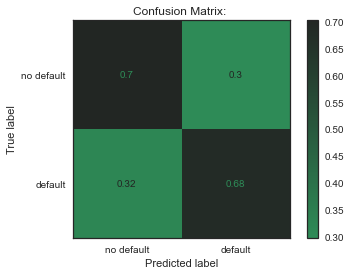

              precision    recall  f1-score   support

  no default       0.96      0.70      0.81    226148
     default       0.17      0.68      0.27     19860

    accuracy                           0.70    246008
   macro avg       0.57      0.69      0.54    246008
weighted avg       0.90      0.70      0.77    246008




In [ ]:
h.plot_classifier_scores(pipe_lr_1, X_train_lg, y_train, y_hat_train_lr_1, labels)

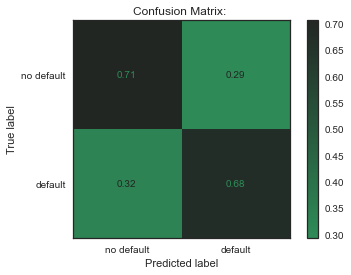

              precision    recall  f1-score   support

  no default       0.96      0.71      0.81     28269
     default       0.17      0.68      0.27      2482

    accuracy                           0.70     30751
   macro avg       0.56      0.69      0.54     30751
weighted avg       0.90      0.70      0.77     30751




In [ ]:
h.plot_classifier_scores(pipe_lr_1, X_val_lg, y_val, y_hat_val_lr_1, labels)

It's not capturing the lower class in a way I would want. It would be ok to raise the precision of default cases, but I think the recall is more important. It would be better to predict more default (business would have possibility to raise the interest rate for example) when it was not the default case, as then it wouldn't loose money. I need to try to raise the number of default predictions.

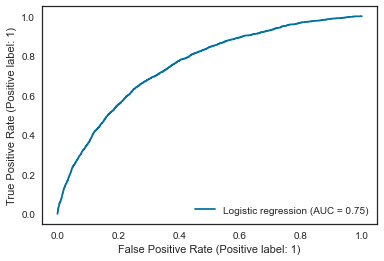

In [ ]:
h.plot_roc_curve(pipe_lr_1, X_val_lg, y_val, ax = plt.gca(),name = "Logistic regression")

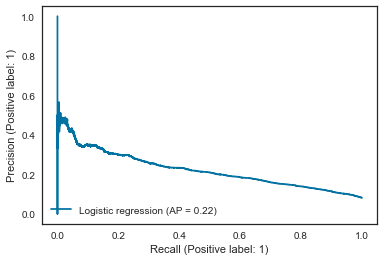

In [ ]:
h.plot_precision_recall_curve(pipe_lr_1, X_val_lg, y_val, ax = plt.gca(),name = "Logistic regression")

We can see that the are under precision/recall curve is bad, as we have a very low precision of default cases and the recall is actually not brilliant too. Let's try to lower down the number of features, maybe the dimensionality reduction would help the model to capture relationships and patterns better.

* Miss classifications.

In [ ]:
missed_lg_1 = X_val_lg[(y_val == 1) & (y_hat_val_lr_1 == 0)]
missed_lg_1.shape

(804, 87)

That's a lot missclassifications of defaults (30 percent of defaults are not captured).

In [ ]:
missed_0_lr_1 = X_val_lg[(y_val == 0) & (y_hat_val_lr_1 == 1)]
missed_0_lr_1.shape

(8301, 87)

We can see that there were misclassified lots over 8 hundred default cases and over 8 thousand non default cases. After investigating the features of these misclassifications, I could not find some kind of certain pattern, why these misclassifications could happen.

### 3.2. Optimal Threshold by the ROC CURVE

I used the geometric mean or known as G-mean is the geometric mean of sensitivity (known as recall - True positive rate) and specificity(False positive rate). So, it will be one of the unbiased evaluation metrics for imbalanced classification [idea from here](https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293). And the rest of threshold adding to the Logistic Regression [from here](https://towardsdatascience.com/calculating-and-setting-thresholds-to-optimise-logistic-regression-performance-c77e6d112d7e).

Best Threshold: 1 with G-Mean: 0.691
FPR: 0.2936, TPR: 0.6761


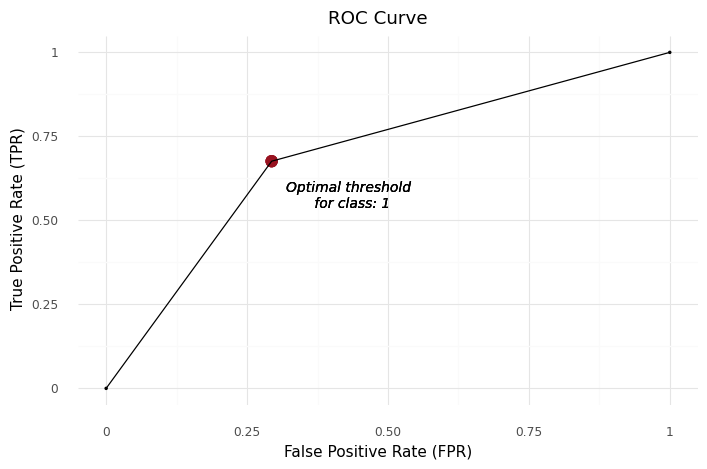

<ggplot: (154131238717)>

In [ ]:
# h.optimal_threshold_ROC_AUC_G_mean(y_val, y_hat_val_lr_1)

I'll try how changes the outcomes according to this threshold. 

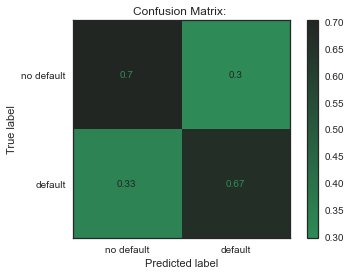

              precision    recall  f1-score   support

  no default       0.94      0.89      0.92     28269
     default       0.24      0.40      0.30      2483

    accuracy                           0.85     30752
   macro avg       0.59      0.64      0.61     30752
weighted avg       0.89      0.85      0.87     30752




In [ ]:
y_hat_test_lr_1_threshold = (pipe_lr_1.predict_proba(X_test_lg)[:,1] >= 0.691).astype(bool)
h.plot_classifier_scores(pipe_lr_1, X_test_lg, y_test, y_hat_test_lr_1_threshold, labels)

So, if we change that default threshold from 0.5 to 0.691 we reduced the recall of defaults and increased the precision of defaults. This means that with this threshold we reached more balanced f1 score, but would have more guessed True defaults between all guessed defaults, but less guessed True defaults between all defaults in real. We could be a little bit more certain about the default predictions. If the business would want this kind of optimization, to change the threshold in the Logistic Regression is not so easy, a Class can be written [example here](https://towardsdatascience.com/calculating-and-setting-thresholds-to-optimise-logistic-regression-performance-c77e6d112d7e).

### 3.3. Additional feature selection by most important ones

Coefficients of features in logistic regression.

In [ ]:
features = h.feature_names(pipe_lr_1, numerical_features_lg, binary_features_lg, remainder_features)

In [ ]:
coeff = pd.DataFrame(pipe_lr_1["classifier"].coef_, columns=features)
coeff_transf = coeff.T
coeff_transf.rename({0:"coefficient"}, axis=1, inplace=True)
coeff_transf.sort_values(by="coefficient", ascending=False).head(5)

,coefficient
name_education_type,8.40
organization_type,5.77
occupation_type,4.80
employment_bins,4.52
name_family_status,2.06


In [ ]:
coeff_transf.sort_values(by="coefficient", ascending=False).tail()

,coefficient
ext_source_3,-0.47
name_contract_type,-0.56
region_rating_client_w_city,-1.25
log_prev_amt_annuity_mean_hc,-2.16
age_bins,-5.48


Largest and smallest coefficient were assigned to these features: type of the loan, age, region, where the client lives in, previous loan annuity amount, education, organization and occupation types, employment length, status of the family.

* I decided to choose only the important to the model features, where the coefficient is higher that 0.2 or lower that -0.2, as coefficient of 0.0, means the feature is actually excluded.

In [ ]:
important_features = coeff_transf[
    (coeff_transf["coefficient"] >= 0.2) | (coeff_transf["coefficient"] <= -0.2)
].index.to_list()

* New sets of train, val, test with lower number of features.

In [ ]:
X_train_lg_less = X_train_lg[important_features].copy()
X_val_lg_less = X_val_lg[important_features].copy()
X_test_lg_less = X_test_lg[important_features].copy()

In [ ]:
# Features in the X_lg_less.

binary_features_lg_less = [
    "name_contract_type",
    "code_gender",
    "flag_own_car",
]

categorical_features_lg_less = [
    "name_housing_type",
    "occupation_type",
    "name_education_type",
    "name_family_status",
    "organization_type",
    "employment_bins",
    "age_bins",
    "name_income_type",
]

numerical_features_lg_less = [
    "ext_source_1",
    "ext_source_2",
    "ext_source_3",
    "log_prev_amt_credit_mean_hc",
    "log_prev_amt_annuity_mean_hc",
    "approved_hc_name_contract_type_Cash loans_normalized",
    "approved_hc_name_contract_type_Consumer loans_normalized",
    "approved_hc_name_contract_type_Revolving loans_normalized",
    "approved_hc_name_client_type_New_normalized",
    "approved_hc_name_client_type_Refreshed_normalized",
    "approved_hc_name_client_type_Repeater_normalized",
    "approved_hc_name_yield_group_XNA_normalized",
    "approved_hc_name_yield_group_high_normalized",
    "approved_hc_name_yield_group_low_action_normalized",
    "approved_hc_name_yield_group_low_normal_normalized",
    "approved_hc_name_yield_group_middle_normalized",
    "total_future_instalments_by_other_credts_hc",
    "log_min_instal_amt_per_prev_credit_hc",
    "log_max_instal_amt_per_prev_credit_hc",
    "mean_drawings_per_1cred_card_hc",
    "mean_credit_card_payment_hc",
]

remainder_features_less = ["region_rating_client_w_city", "flag_mobil"]

In [ ]:
# Transformers for data sets of lower number of features.

binary_transformer_lg_less = Pipeline(steps=[("encoder", OrdinalEncoder())])

target_transformer_lg_less = Pipeline(
    steps=[
        (
            "encoder",
            ce.TargetEncoder(
                cols=categorical_features_lg_less,
                drop_invariant=True,
                handle_missing="value",
                handle_unknown="value",
            ),
        )
    ]
)

numerical_scaler_lg_less = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor_lg_less = ColumnTransformer(
    transformers=[
        ("numeric", numerical_scaler_lg_less, numerical_features_lg_less),
        (
            "categorical_target",
            target_transformer_lg_less,
            categorical_features_lg_less,
        ),
        ("binary", binary_transformer_lg_less, binary_features_lg_less),
    ],
    remainder="passthrough",
)

resample = SMOTETomek(tomek=TomekLinks(sampling_strategy="majority"), random_state=123)

* Second Logistic regression with lower number of features.

In [ ]:
pipe_lr_2 = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_lg_less),
        ("resample", resample),
        ("classifier", LogisticRegression(solver="saga", n_jobs=-1,class_weight="balanced", max_iter=1000)),
    ]
)

In [ ]:
pipe_lr_2.fit(X_train_lg_less, y_train)

In [ ]:
y_hat_train_lr_2 = pipe_lr_2.predict(X_train_lg_less)
y_hat_val_lr_2 = pipe_lr_2.predict(X_val_lg_less)

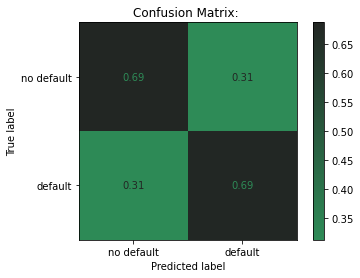

              precision    recall  f1-score   support

  no default       0.96      0.69      0.80     28267
     default       0.16      0.69      0.26      2484

    accuracy                           0.69     30751
   macro avg       0.56      0.69      0.53     30751
weighted avg       0.90      0.69      0.76     30751




In [ ]:
h.plot_classifier_scores(pipe_lr_2, X_val_lg_less, y_val, y_hat_val_lr_2, labels)

On validation data we got even lower scores after feature elimination. Tis approach did not help.

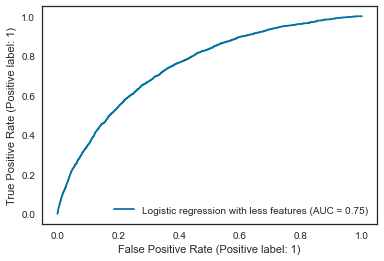

In [ ]:
plot_roc_curve(pipe_lr_2, X_val_lg_less, y_val, ax = plt.gca(),name = "Logistic regression with less features")

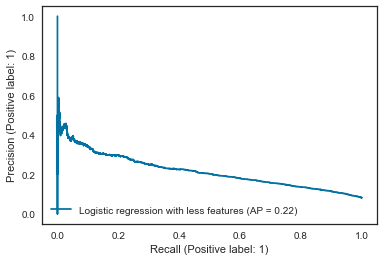

In [ ]:
plot_precision_recall_curve(pipe_lr_2, X_val_lg_less, y_val, ax = plt.gca(),name = "Logistic regression with less features")

This approach did not help, reducing features by the coefficient did't help to improve ROC_AUC anr Precision_Recall scores.

### 3.4. Reducing the number of features with PCA

I'll try to reduce the number of features, given to the model, with the help of Principal component analysis - unsupervised learning technique.

In [ ]:
# Setting the n_components to the proportion (or percentage) of information I want the PCA to capture.

pca = PCA(n_components=0.95, random_state=123)
pipe_lr_4 = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_lg),
        ("pca", pca),
        ("classifier", LogisticRegression(solver="saga", n_jobs=-1,class_weight="balanced", max_iter=1000)),
    ]
)

In [ ]:
pipe_lr_4.fit(X_train_lg, y_train)

In [ ]:
y_hat_train_lr_4 = pipe_lr_4.predict(X_train_lg)
y_hat_val_lr_4 = pipe_lr_4.predict(X_val_lg)

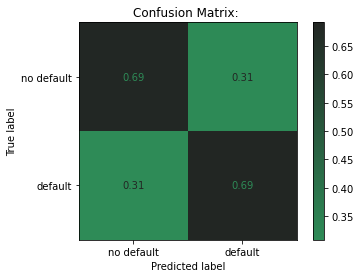

              precision    recall  f1-score   support

  no default       0.96      0.69      0.80     28267
     default       0.16      0.69      0.26      2484

    accuracy                           0.69     30751
   macro avg       0.56      0.69      0.53     30751
weighted avg       0.90      0.69      0.76     30751




In [ ]:
h.plot_classifier_scores(pipe_lr_4, X_val_lg, y_val, y_hat_val_lr_4, labels)

The F1 score (harmonic mean of precision and recall, the measurement of default cases that i was mostly interested in)had even dropped. Seems that PCA is not helping.

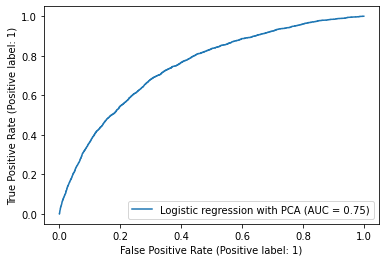

In [ ]:
plot_roc_curve(pipe_lr_4, X_val_lg, y_val, ax = plt.gca(),name = "Logistic regression with PCA")

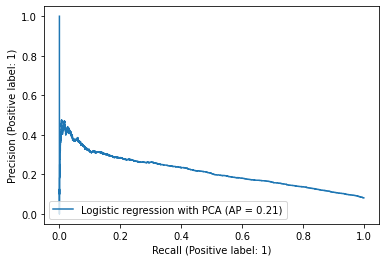

In [ ]:
plot_precision_recall_curve(pipe_lr_4, X_val_lg, y_val, ax = plt.gca(),name = "Logistic regression with PCA")

Trying to reduce dimensionality (while obtaining 95 percent of the (information) variance of the d But the main problem still exists, the model cannot capture well the difference between two classes and the SMOTE did not totally overcome the imbalance in this data.

### 3.5. Reducing dimensionality with LinearDiscriminantAnalysis

As in PCA we were only interested in the component axes that maximize the variance in the data, while in LDA we have the additional goal of maximizing the differences between classes (it's supervised ML technique). That's why I decided to try it.

I tried actually to count, how many n_component I need to gather 95 percent of the whole information, using LDA, but that was useless, as when you have only two target classes, n_components will be 1. So the counting has more point to do with multi class targets. Let's try to fit Linear Discriminant Analysis as pre-processor to reduce dimensionality and get the maximum separability of the target classes.

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=1)
pipe_lr_3 = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_lg),
        ("lda", lda),
        ("classifier", LogisticRegression(solver="saga", n_jobs=-1,class_weight="balanced", max_iter=1000)),
    ]
)

In [ ]:
pipe_lr_3.fit(X_train_lg, y_train)

In [ ]:
y_hat_train_lr_3 = pipe_lr_3.predict(X_train_lg)
y_hat_val_lr_3 = pipe_lr_3.predict(X_val_lg)

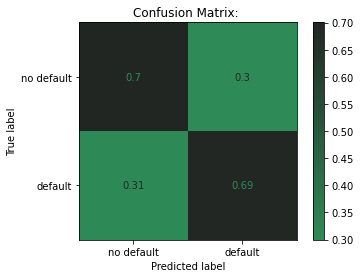

              precision    recall  f1-score   support

  no default       0.96      0.70      0.81     28267
     default       0.17      0.69      0.27      2484

    accuracy                           0.70     30751
   macro avg       0.57      0.70      0.54     30751
weighted avg       0.90      0.70      0.77     30751




In [ ]:
h.plot_classifier_scores(pipe_lr_3, X_val_lg, y_val, y_hat_val_lr_3, labels)

Even using Linear Discriminant Analysis technique to separate the classes as much as possible, I got almost the same scores of default cases and with using SMOTE resampling.

### 3.6. Hyperparameter tuning

As non of the dimensionality reduction techniques had helped to improve models scores, I'll try  to tune the hyperparameter of the first logistic regression (with all features included).

In [ ]:
study = optuna.create_study(direction="maximize", study_name="LogisticRegression")
func = lambda trial: h.logistic_regression_objective(trial, X_train_lg, y_train, preprocessor_lg, resample)
study.optimize(func, n_trials=20)

In [ ]:
trial = study.best_trial
lg_params = trial.params

In [ ]:
for key, value in lg_params.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value (roc_auc): {study.best_value:.5f}')


		penalty: l2
		C: 4.203498758310692
		class_weight: None
	Best value (roc_auc): 0.75021


In [ ]:
pipe_lr_5 = ImPipeline(
    steps=[
        ("preprocessor", preprocessor_lg),
        ("resample", resample),
        ("classifier", LogisticRegression(solver="saga", n_jobs=-1, **lg_params)),
    ]
)

In [ ]:
pipe_lr_5.fit(X_train_lg, y_train)

In [ ]:
y_hat_train_lr_5 = pipe_lr_5.predict(X_train_lg)
y_hat_val_lr_5 = pipe_lr_5.predict(X_val_lg)

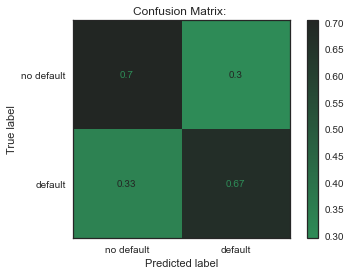

              precision    recall  f1-score   support

  no default       0.96      0.70      0.81     28269
     default       0.17      0.67      0.27      2482

    accuracy                           0.70     30751
   macro avg       0.56      0.69      0.54     30751
weighted avg       0.90      0.70      0.77     30751




In [ ]:
h.plot_classifier_scores(pipe_lr_5, X_val_lg, y_val, y_hat_val_lr_5, labels)

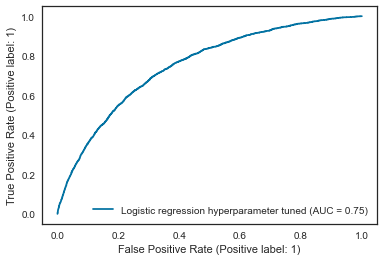

In [ ]:
plot_roc_curve(pipe_lr_5, X_val_lg, y_val, ax = plt.gca(),name = "Logistic regression hyperparameter tuned")

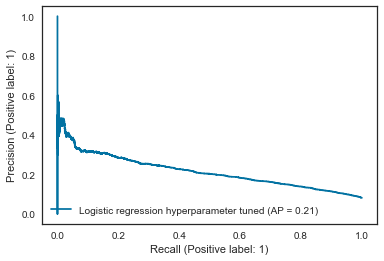

In [ ]:
plot_precision_recall_curve(pipe_lr_5, X_val_lg, y_val, ax = plt.gca(),name = "Logistic regression hyperparameter tuned")

After hyperparameter tuning the models performance got worse. With my set and default hyperparameter logistic regression did a little bit better.

# 4. LGBM Classifier

### 4.1. Feature pre-processing and basic LGBM Classifier

As LGBM is a tree based model, it doesn't need feature scaling and can accept categorical data, so I'll prepare different train, val, test sets for this model (no need for cos/sin time values and some binning of the numerical data as there we cannot find linear relationships or use two features in parallel).

In [ ]:
# Dropping some columns.
X_train_lgbm = (
    X_train.pipe(h.copy_df)
    .pipe(h.drop_columns, [
        "cos_hour_appr_process_start",	
        "sin_hour_appr_process_start",	
        "cos_weekday_appr_process_start",	
        "sin_weekday_appr_process_start",
        "age_bins",
        "employment_bins"
    ]))

X_val_lgbm = (
    X_val.pipe(h.copy_df)
    .pipe(h.drop_columns, [
        "cos_hour_appr_process_start",	
        "sin_hour_appr_process_start",	
        "cos_weekday_appr_process_start",	
        "sin_weekday_appr_process_start",
        "age_bins",
        "employment_bins"
    ]))

X_test_lgbm = (
    X_test.pipe(h.copy_df)
   .pipe(h.drop_columns, [
        "cos_hour_appr_process_start",	
        "sin_hour_appr_process_start",	
        "cos_weekday_appr_process_start",	
        "sin_weekday_appr_process_start",
        "age_bins",
        "employment_bins"
    ]))

* Simple not tuned LightGBM with inputted categorical features straight into the model, no scaling and no resampling. Dealing with imbalance with class_weight only.

In [ ]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : "auc", 
            "eval_set" : [(X_val_lgbm,y_val)],
            "eval_names": ["valid"],
            "verbose": 100,
            "feature_name": "auto", 
            "categorical_feature": "auto",
           }
lgbm_1 =LGBMClassifier(num_leaves= 15, max_depth=-1, 
                         random_state=123, 
                         silent=True, 
                         metric="None", 
                         n_jobs=-1, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1, 
                         class_weight="balanced")

In [ ]:
lgbm_1.fit(X_train_lgbm, y_train, **fit_params)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.767549
[200]	valid's auc: 0.770036
Early stopping, best iteration is:
[255]	valid's auc: 0.77112


LGBMClassifier(class_weight='balanced', colsample_bytree=0.9, metric='None',
               n_estimators=1000, num_leaves=15, random_state=123,
               subsample=0.9)

In [ ]:
y_hat_train_lgbm = lgbm_1.predict(X_train_lgbm)
y_hat_val_lgbm = lgbm_1.predict(X_val_lgbm)

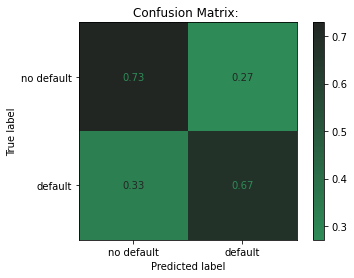

              precision    recall  f1-score   support

  no default       0.96      0.73      0.83     28269
     default       0.18      0.67      0.28      2482

    accuracy                           0.72     30751
   macro avg       0.57      0.70      0.56     30751
weighted avg       0.90      0.72      0.79     30751




In [ ]:
h.plot_classifier_scores(lgbm_1, X_val_lgbm, y_val, y_hat_val_lgbm, labels)

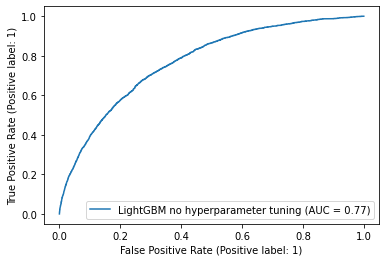

In [ ]:
h.plot_roc_curve(lgbm_1, X_val_lgbm, y_val, ax = plt.gca(),name = "LightGBM no hyperparameter tuning")

* Optimal threshold by ROC_AUC curve.

Best Threshold: 1 with G-Mean: 0.7011
FPR: 0.2712, TPR: 0.6745


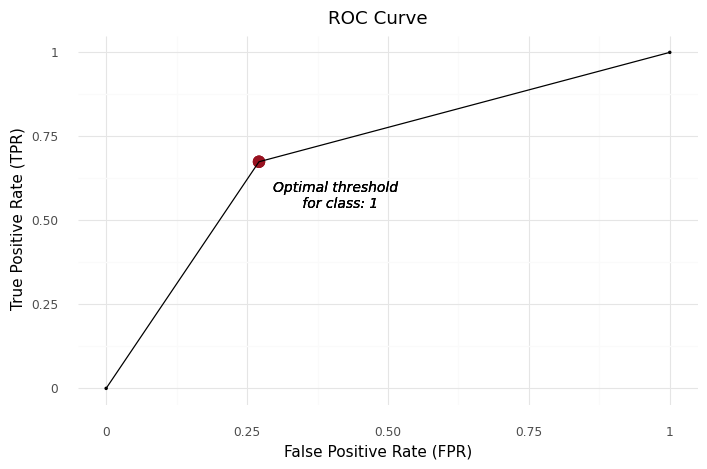

<ggplot: (154175181960)>

In [ ]:
# h.optimal_threshold_ROC_AUC_G_mean(y_val, y_hat_val_lgbm)

I'll try how changes the outcomes according to this threshold. 

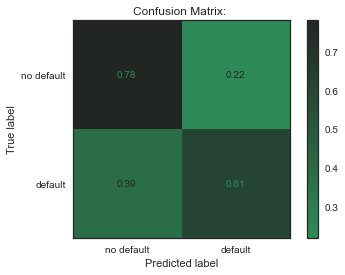

              precision    recall  f1-score   support

  no default       0.94      0.93      0.93     28269
     default       0.29      0.33      0.31      2483

    accuracy                           0.88     30752
   macro avg       0.61      0.63      0.62     30752
weighted avg       0.89      0.88      0.88     30752




In [ ]:
y_hat_test_lgbm_threshold = (lgbm_1.predict_proba(X_test_lgbm)[:,1] >= 0.7011).astype(bool)
h.plot_classifier_scores(lgbm_1, X_test_lgbm, y_test, y_hat_test_lgbm_threshold, labels)

If we would select this optimal threshold, we would lower down the recall of defaults a lot. I don't think that's an option, but the model has a little bit better F1 score and looks maybe more stable as precision and recall of defaults are quite equal.

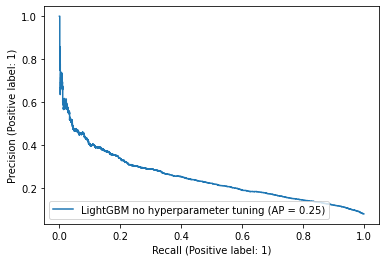

In [ ]:
plot_precision_recall_curve(lgbm_1, X_val_lgbm, y_val, ax = plt.gca(),name = "LightGBM no hyperparameter tuning")

Actually we can see some improvement from the base line model and from the Logistic regression in ROC_AUC score by 1 point (from 0.76 to 0.77) and precision_recall area under the curve is 0.25 (earlier highest was 0.22).

* Feature importance by SHAP values.

In [ ]:
features_lgbm = X_train_lgbm.columns.to_list()

In [ ]:
explainer = shap.TreeExplainer(lgbm_1.booster_)
shap_values = explainer.shap_values(X_val_lgbm)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


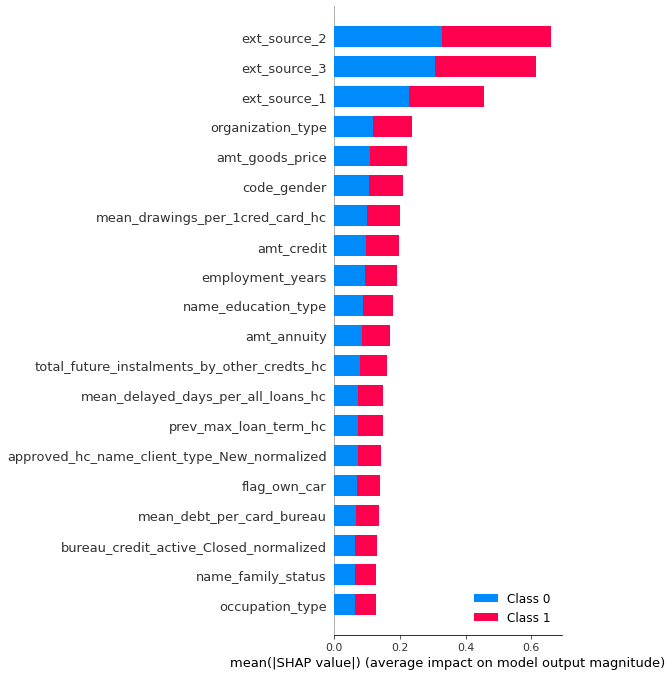

In [ ]:
shap.summary_plot(shap_values, X_val_lgbm)

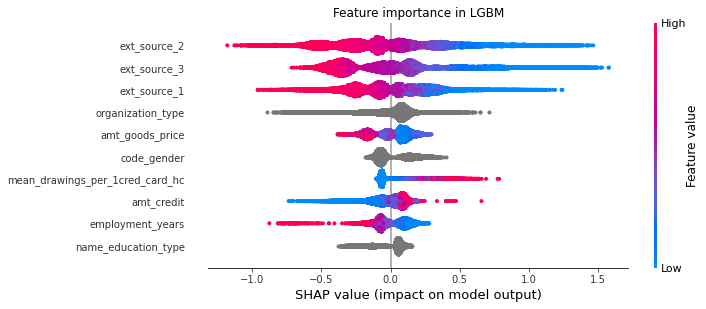

In [ ]:
shap.summary_plot(
    shap_values[-1],
    X_val_lgbm,
    feature_names=features_lgbm,
    max_display=10,
    show=False,
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 4)
ax.set_title("Feature importance in LGBM", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)

For example my engineered feature mean_drawings_per_1cred_card_hc is quite impacted, so it is nice.

In [ ]:
# plot the SHAP values for the stroke "1" output in y_val 0 instance
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][5, :], X_val_lgbm.iloc[5, :], link="logit", feature_names=features_lgbm)

I took the 5'th instance of the y_val set, the output was "1" and checked what shows the shap values. It shows that the base value was 0.3694, predict_proba = 0.65 and to this output took ext_source_3, mean_delayed_days_per_all_loans, ext_source_1 and goods_price. So these features increased the probability into the right way and decision.

### 4.2. Numeric feature selection with RFECV

First of all i could not select optimal number of all features, as even with LGBM classifier RFECV did not handle categorical features, only numerical. So having that in mind, I want to see what is the optimal number of numerical features and after all add categorical features back. For this task, I will create an RFECV graph that will provide us with a score and the number of features. This will help us determine how many features we should keep.

In [ ]:
X_train_lgbm_numeric = X_train_lgbm.select_dtypes(exclude="category")
len(X_train_lgbm_numeric.columns)

74

In total we have 74 numeric features.

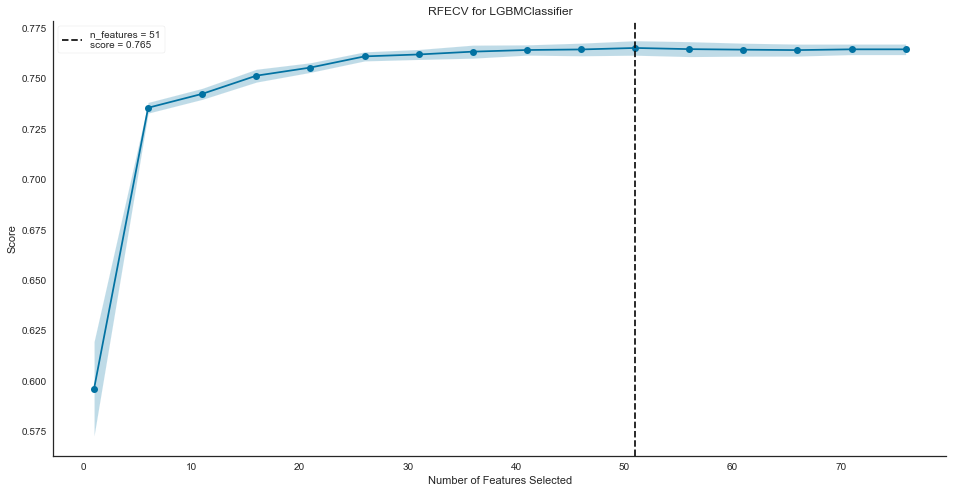

In [ ]:
sns.set_style("ticks")
plt.figure(figsize=(16, 8))
visualizer = RFECV(LGBMClassifier(), step=5, cv=3, scoring="roc_auc", color="#7800FF")

visualizer.fit(X_train_lgbm_numeric, y_train)
sns.despine()
visualizer.show()
None

So the optimal number of numerical features to keep is 51, which gives us the ROC _AUC score of 0.765, plus having in mind additional categorical features, that I excluded for now. Let's see which numerical features should be kept.

In [ ]:
rfecv = RFECV(
    estimator=LGBMClassifier(),
    min_features_to_select=51,
    step=5,
    n_jobs=-1,
    scoring="roc_auc",
    cv=5,
)

_ = rfecv.fit(X_train_lgbm_numeric, y_train)

col_to_keep = X_train_lgbm_numeric.columns[rfecv.support_]

I got the list of selected numerical features, now let's combine and throw into the model.

### 4.3. LGBM with lower number of features, according to the RFECV selection

In [ ]:
numerical_cols = list(col_to_keep)
categorical_cols = X_train_lgbm.select_dtypes(include="category").columns.to_list()

columns_to_keep = numerical_cols + categorical_cols
X_train_lgbm_less = X_train_lgbm[columns_to_keep]
X_val_lgbm_less = X_val_lgbm[columns_to_keep]
X_test_lgbm_less = X_test_lgbm[columns_to_keep]

In [ ]:
X_train_lgbm_less.head()

,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,cnt_fam_members,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,ext_source_1,ext_source_2,ext_source_3,def_30_cnt_social_circle,obs_60_cnt_social_circle,submitted_addit_docs,prop_of_provided_living_place_info,age_years,last_reg_change_in_years,last_phone_change_in_years,employment_years,id_published_years,prev_approved_hc,prev_amt_credit_mean_hc,prev_amt_annuity_mean_hc,prev_min_loan_term_hc,prev_max_loan_term_hc,prev_days_from_last_approval_hc,approved_hc_name_contract_type_Consumer loans_normalized,approved_hc_name_client_type_New_normalized,approved_hc_name_client_type_Refreshed_normalized,approved_hc_name_client_type_Repeater_normalized,approved_hc_name_yield_group_high_normalized,approved_hc_name_yield_group_low_action_normalized,approved_hc_name_yield_group_low_normal_normalized,approved_hc_name_yield_group_middle_normalized,total_appl_hc,total_rejected_appl_hc,prev_reject_amt_appl_mean_hc,mean_delayed_days_per_all_loans_hc,total_delayed_days_per_all_loans_hc,total_future_instalments_by_other_credts_hc,min_instal_amt_per_prev_credit_hc,max_instal_amt_per_prev_credit_hc,mean_instal_amt_per_prev_credit_hc,total_instalments_amt_prev_credit_hc,max_total_per_1cred_card_limit_hc,mean_total_per_1cred_card_limit_hc,mean_drawings_per_1cred_card_hc,mean_credit_card_payment_hc,total_default_days_per_all_cred_cards_hc,total_credits_bureau,total_credit_types_count_bureau,mean_debt_per_card_bureau,mean_credit_per_card_bureau,bureau_credit_active_Active_normalized,bureau_credit_active_Closed_normalized,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type,organization_type
305637,135000.00,1061599.50,31171.50,927000.00,0.02,2,2,7,9,0.59,0.43,0.53,0,6,0.05,0.32,49.52,21.32,2.67,3.02,4.42,2.00,338296.50,23250.11,12.00,36.00,491.00,0.00,0.50,0.00,0.50,0.50,0.00,0.00,0.50,4.00,0.00,0.00,0.00,0.00,5.00,18572.41,27824.64,23198.53,1113257.48,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,17055.00,0.00,1.00,cash_loans,m,y,y,family,working,secondary_secondary_special,married,house_apartment,drivers,business_entity_type_3
152596,216000.00,760131.00,28057.50,634500.00,0.03,2,2,3,15,0.65,0.67,0.36,0,2,0.05,0.21,53.59,25.35,1.66,16.79,8.54,2.00,366750.00,18152.19,24.00,30.00,396.00,1.00,0.50,0.00,0.50,0.00,0.00,1.00,0.00,2.00,0.00,0.00,0.00,0.00,25.00,11701.80,24602.58,18152.19,619572.42,0.00,0.00,0.00,0.00,0.00,6.00,2.00,7810.72,147826.50,0.50,0.50,cash_loans,m,n,y,unaccompanied,working,secondary_secondary_special,married,house_apartment,laborers,business_entity_type_2
64100,247500.00,675000.00,21906.00,675000.00,0.03,2,2,1,14,0.54,0.65,0.51,0,0,0.05,0.00,43.22,27.09,1.30,3.55,11.06,5.00,346113.90,18507.00,0.00,48.00,75.00,0.40,0.20,0.20,0.60,0.00,0.00,0.40,0.40,11.00,3.00,464235.00,0.00,0.00,6.00,3244.17,140678.57,49514.04,1852559.64,2880000.00,2880000.00,302366.11,55150.96,0.00,4.00,2.00,39003.75,133153.88,0.50,0.50,cash_loans,f,n,y,unaccompanied,working,secondary_secondary_special,married,house_apartment,security_staff,security
24351,189000.00,355536.00,18283.50,270000.00,0.01,2,2,2,10,0.70,0.60,0.12,0,0,0.05,0.29,57.93,6.28,0.89,36.68,11.35,1.00,14967.00,4116.82,4.00,4.00,326.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,4116.80,4116.80,4116.80,16467.21,0.00,0.00,0.00,0.00,0.00,11.00,2.00,64031.55,196647.60,0.73,0.27,cash_loans,m,n,y,unaccompanied,working,secondary_secondary_special,civil_marriage,house_apartment,laborers,business_entity_type_2
118194,85500.00,99000.00,9774.00,99000.00,0.03,1,2,3,12,0.73,0.48,0.77,1,1,0.05,0.18,62.87,1.09,0.42,11.53,11.49,3.00,49711.50,9401.88,6.00,6.00,155.00,0.67,0.33,0.67,0.00,0.33,0.00,0.00,0.67,5.00,1.00,202500.00,0.00,0.00,2.00,9180.23,14592.78,11471.44,153711.09,0.00,0.00,0.00,0.00,0.00,3.00,1.00,22356.00,178152.00,0.33,0.67,cash_loans,f,n,y,unaccompanied,pensi

In [ ]:
len(X_train_lgbm_less.columns)

67

In [ ]:
fit_params={"early_stopping_rounds":50, 
            "eval_metric" : "auc", 
            "eval_set" : [(X_val_lgbm_less,y_val)],
            "eval_names": ["valid"],
            "verbose": 100,
            "feature_name": "auto", 
            "categorical_feature": "auto",
           }
lgbm_2 =LGBMClassifier(num_leaves= 15, max_depth=-1, 
                         random_state=123, 
                         silent=True, 
                         metric="None", 
                         n_jobs=-1, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1, 
                         class_weight="balanced")

In [ ]:
lgbm_2.fit(X_train_lgbm_less, y_train, **fit_params)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 50 rounds
[100]	valid's auc: 0.767775
[200]	valid's auc: 0.770061
[300]	valid's auc: 0.7711
Early stopping, best iteration is:
[340]	valid's auc: 0.771187


LGBMClassifier(class_weight='balanced', colsample_bytree=0.9, metric='None',
               n_estimators=1000, num_leaves=15, random_state=123,
               subsample=0.9)

In [ ]:
y_hat_train_lgbm_2 = lgbm_2.predict(X_train_lgbm_less)
y_hat_val_lgbm_2 = lgbm_2.predict(X_val_lgbm_less)

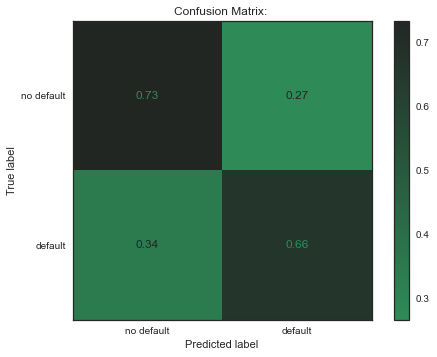

              precision    recall  f1-score   support

  no default       0.96      0.73      0.83     28269
     default       0.18      0.66      0.28      2482

    accuracy                           0.73     30751
   macro avg       0.57      0.70      0.56     30751
weighted avg       0.90      0.73      0.79     30751




In [ ]:
h.plot_classifier_scores(lgbm_2, X_val_lgbm_less, y_val, y_hat_val_lgbm_2, labels)

Actually the recall of the default cases reduced, so that doesn't satisfy me.

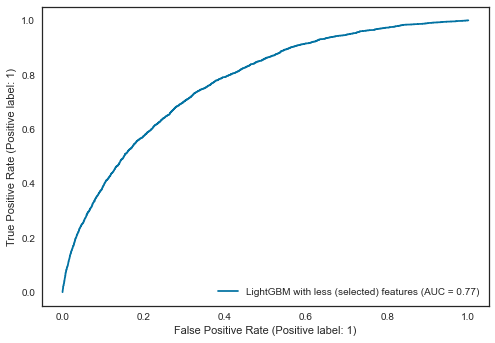

In [ ]:
plot_roc_curve(lgbm_2, X_val_lgbm_less, y_val, ax = plt.gca(),name = "LightGBM with less (selected) features")

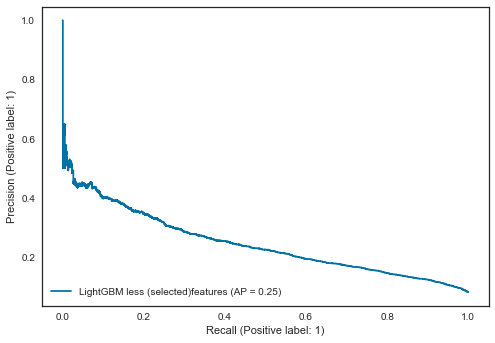

In [ ]:
plot_precision_recall_curve(lgbm_2, X_val_lgbm_less, y_val, ax = plt.gca(),name = "LightGBM less (selected)features")

Actually even lowering down the number of features did not improve the performance of the model. 

### 4.4. LGBM hyperparameter tuning

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM")
func = lambda trial: h.LGBM_objective(trial, X_train_lgbm, y_train)
study.optimize(func, n_trials=20)

In [ ]:
trial = study.best_trial
lgbm_params = trial.params

In [ ]:
for key, value in lgbm_params.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value (binary_log_loss): {study.best_value:.5f}')


		n_estimators: 818
		learning_rate: 0.23227195937848208
		num_leaves: 940
		max_depth: 3
		min_data_in_leaf: 2100
		lambda_l1: 20
		lambda_l2: 40
	Best value (binary_log_loss): 0.55244


In [ ]:
lgbm_3 =LGBMClassifier(class_weight="balanced", **lgbm_params)

In [ ]:
lgbm_3.fit(X_train_lgbm, y_train)

LGBMClassifier(class_weight='balanced', lambda_l1=20, lambda_l2=40,
               learning_rate=0.23227195937848208, max_depth=3,
               min_data_in_leaf=2100, n_estimators=818, num_leaves=940)

In [ ]:
y_hat_train_lgbm_3 = lgbm_3.predict(X_train_lgbm)
y_hat_val_lgbm_3 = lgbm_3.predict(X_val_lgbm)

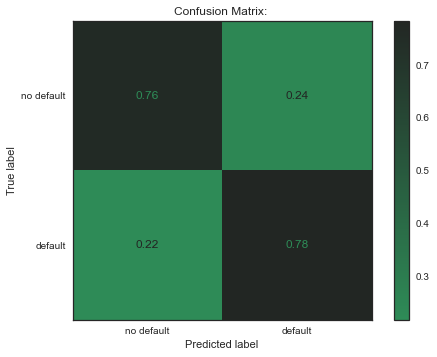

              precision    recall  f1-score   support

  no default       0.98      0.76      0.85    226148
     default       0.22      0.78      0.35     19860

    accuracy                           0.76    246008
   macro avg       0.60      0.77      0.60    246008
weighted avg       0.91      0.76      0.81    246008




In [ ]:
h.plot_classifier_scores(lgbm_3, X_train_lgbm, y_train, y_hat_train_lgbm_3, labels)

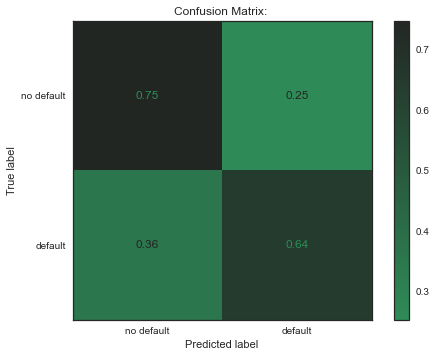

              precision    recall  f1-score   support

  no default       0.96      0.75      0.84     28269
     default       0.18      0.64      0.28      2482

    accuracy                           0.74     30751
   macro avg       0.57      0.70      0.56     30751
weighted avg       0.90      0.74      0.80     30751




In [ ]:
h.plot_classifier_scores(lgbm_3, X_val_lgbm, y_val, y_hat_val_lgbm_3, labels)

The recall of default dropped after hyperparameter tuning. So my first LGBM classifier did better in my opinion.

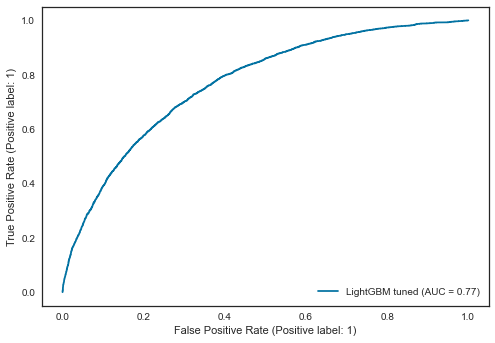

In [ ]:
plot_roc_curve(lgbm_3, X_val_lgbm, y_val, ax = plt.gca(),name = "LightGBM tuned")

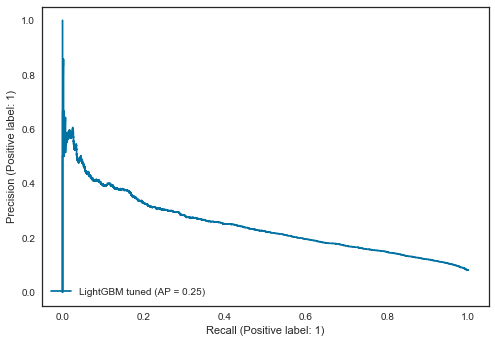

In [ ]:
plot_precision_recall_curve(lgbm_3, X_val_lgbm, y_val, ax = plt.gca(),name = "LightGBM tuned")

The areas under the ROC_AUC and Precision Recall curve are actually the same.

### 4.5. Model Calibration

So, as I decided to choose the first LightGBMClassifier with my chosen set of hyperparameters, let's test how it works on test data.

In [ ]:
y_hat_test_lgbm_1 = lgbm_1.predict(X_test_lgbm)

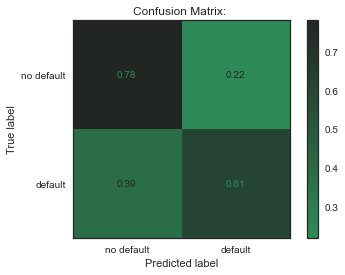

              precision    recall  f1-score   support

  no default       0.96      0.78      0.86     28269
     default       0.20      0.61      0.30      2483

    accuracy                           0.77     30752
   macro avg       0.58      0.70      0.58     30752
weighted avg       0.90      0.77      0.81     30752




In [ ]:
h.plot_classifier_scores(lgbm_1, X_test_lgbm, y_test, y_hat_test_lgbm_1, labels)

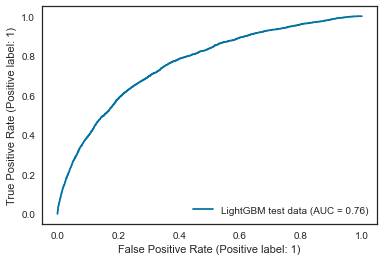

In [ ]:
plot_roc_curve(lgbm_1, X_test_lgbm, y_test, ax = plt.gca(),name = "LightGBM test data")

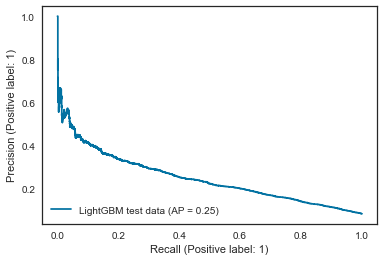

In [ ]:
plot_precision_recall_curve(lgbm_1, X_test_lgbm, y_test, ax = plt.gca(),name = "LightGBM test data")

So we can see that it performs very similarly, maybe a little drop in the ROC_AUC and precision-recall areas, from the validation data.

In [ ]:
# filename = "model_lgbm.joblib"
# dump(lgbm_1, filename)

['model_lgbm.joblib']

* Calibration

In this part, I will calibrate the probabilities and compare them with the non-calibrated model. This will to understand if calibration is necessary. Idea and explanation [from here](https://towardsdatascience.com/classifier-calibration-7d0be1e05452).

color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.


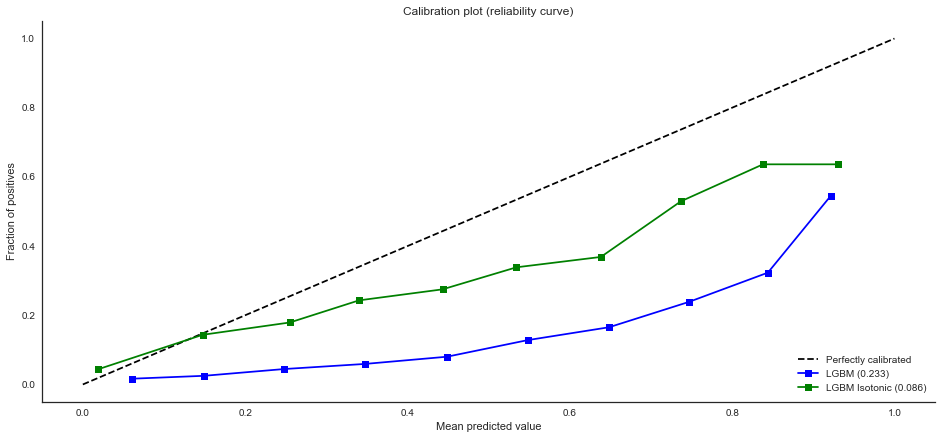

In [ ]:
h.calibration_plot_isotonic(lgbm_1, X_train_lgbm, y_train, X_test_lgbm, y_test)

The classifier overestimates when predicting actually all probabilities. For instance, from the plot above we can see that, for samples for which the model predicted the possibility of being positive to be around 30%, only ~ 5% of them were indeed positive. The dotted diagonal line represents a perfectly calibrated model.
I would recommend to calibrate the model, if the client will use predict_proba to see if the model certain about some decision or it's not. Let's see the output of calibrated LightGBMClassifier.

In [ ]:
calibrated_lgbm = CalibratedClassifierCV(lgbm_1, cv="prefit", method="isotonic")
calibrated_lgbm.fit(X_train_lgbm, y_train)
y_test_hat_caibrated_lgbm = calibrated_lgbm.predict(X_test_lgbm)

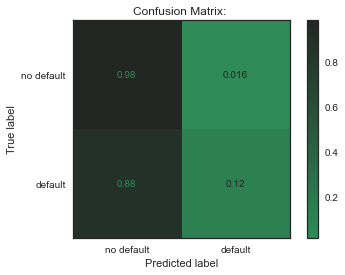

              precision    recall  f1-score   support

  no default       0.93      0.98      0.95     28269
     default       0.40      0.12      0.18      2483

    accuracy                           0.91     30752
   macro avg       0.66      0.55      0.57     30752
weighted avg       0.88      0.91      0.89     30752




In [ ]:
h.plot_classifier_scores(calibrated_lgbm, X_test_lgbm, y_test, y_test_hat_caibrated_lgbm, labels)

After model calibration we can see that the scores changed dramatically, the precision of "defaults" raised and switched places with the recall, which now is very low=0.12, total F1 got even lower. The scores of "non default" predictions became just perfect. I think this is because of the imbalanced data, and now we have a poor, but calibrated predictor, that doesn't satisfy anybody.

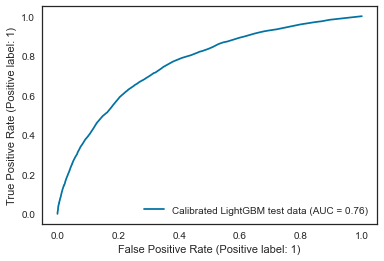

In [ ]:
plot_roc_curve(calibrated_lgbm, X_test_lgbm, y_test, ax = plt.gca(),name = "Calibrated LightGBM test data")

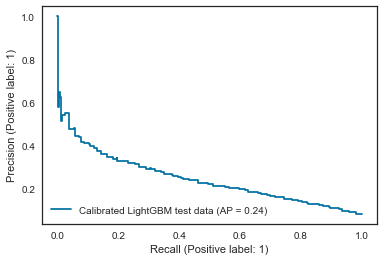

In [ ]:
plot_precision_recall_curve(calibrated_lgbm, X_test_lgbm, y_test, ax = plt.gca(),name = "Calibrated LightGBM test data")

All in all the F1 score did not change dramatically as now we have higher precision and lower recall of the lower in number "default" class.

# Conclusions

* The data was very imbalanced, only 8 percent of cases were default. Different techniques to "fight" with imbalanced data were tried: SMOTE(TomekLinks), weights in the model ("balanced" for example), also  Linear DiscriminantAnalysis (to separate better the classes), I stratified in the splitting part,to ensure that both classes will be in the train, val, test sets. SMOTE helped a little bit without SMOTE I got worse results, but that did not resolve the whole problem in total. Lastly I tried how changing of the probability threshold (according to ROC_AU), would work, it made the decisions and model perform more stable. More "default" cases should be gathered, I think.
* In total, Logistic Regression and LGBM showed quite similar results: ROC_AUC about 0.75-0.77. But these result were actually in all data sets (train, val, test), over fitting was not observed or not so obvious I would say. For future improvement I would try to engineer features even more, maybe combine more of them, to get some rates of these features, to lower down the number of them in this way. I think the sparsity of the data points (because of the large amount of features) could be the problem, why models did not predict better.
* After business decisions, according to the examples: the probability threshold optimisation and model calibration can be made. BUT both these techniques change the outcome. As the precision of a class define how trustable is the result when the model answer that a point belongs to that class and the recall of a class expresses how well the model is able to detect that class. In my opinion it is more important to the model to be able to detect defaults in total (thats recall of defaults). In both cases (after threshold optimisation or model calibration) the recall of defaults dropped drastically.
* Most important features in Logistic Regression by coefficients were: type of the loan, age, region, where the client lives in, previous loan annuity amount, education, organization and occupation types, employment length, status of the family. LGBM Classifier by SHAP values most impactful: all three external source measures (ext_source_1,2,3), organization_type, amt_goods_price, education_type, gender, employment length, mean_drawings per credit card and total credit amount. So last two features were engineered from other data sets, so the work was not useless.
